In [2]:
# 1
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from fenics import *
from mshr import *
from ufl import nabla_grad, nabla_div, grad
from scipy.interpolate import interp2d
import os
import sys
sys.path.append(os.path.realpath('..'))

%matplotlib notebook

In [3]:
# 2
nu = 0.1
cDiff = 0.0027
dbar = 1.6925
cS = 0.5
N = 40*3 # Dimension of the grid
M = 100 # Dimension of the matrices
xmax = 1
tol = 1e-6


In [4]:
# 3
def fun(x, y, muX, muY, sigma):
    return gaussian2d(x, y, muX, muY, sigma, sigma)


def gaussian(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


def gaussian2d(x, y, muX, muY, sigmaX, sigmaY):
    return 1 / (sigmaX * sigmaY * np.sqrt(2 * np.pi)) * np.exp(
        -0.5 * (((x - muX) / sigmaX) ** 2 + ((y - muY) / sigmaY) ** 2))

# N: dimension to, M: dimension from
def interpMat2(N, M, mat):
    xx = np.arange(0, 1.0, 1/(N+1))
    yy = np.arange(0, 1.0, 1/(N+1))
    x = np.arange(0, 1.0, 1/M)
    y = np.arange(0, 1.0, 1/M)
    f = interp2d(x,y,mat)
    mat = f(xx,yy)
    mat = mat.T
    mat = mat.reshape(np.prod(mat.shape))
    return mat

# r = Expression('1 + pow(2, x[0])', degree=2)
# a = Expression('0.5 * (1 - x[0]/xmax)', degree=2, xmax=xmax)
# c_k = Expression('x[0]*x[0]', degree=2)


In [5]:
# 4
x = np.arange(0, 1.0, 1 / M)
y = np.arange(0, 1.0, 1 / M)
X, Y = np.meshgrid(x, y)
zs = np.array(-fun(np.ravel(X), np.ravel(Y), 0.2, 0.5, 0.15)) * 2
zs += np.array(-fun(np.ravel(X), np.ravel(Y), 0.5, 0.3, 0.1))
zs += np.array(-fun(np.ravel(X), np.ravel(Y), 0.5, 0.7, 0.1))
zs += np.array(-fun(np.ravel(X), np.ravel(Y), 0.8, 0.3, 0.1)) * 1.3
zs += np.array(-fun(np.ravel(X), np.ravel(Y), 0.8, 0.7, 0.1)) * 1.3


[-0.05636164 -0.06146514 -0.06673398 ... -0.18243703 -0.15314594
 -0.12727894]
[0.99892292 0.99882539 0.9987247  ... 0.99651359 0.99707335 0.99756768]


<IPython.core.display.Javascript object>


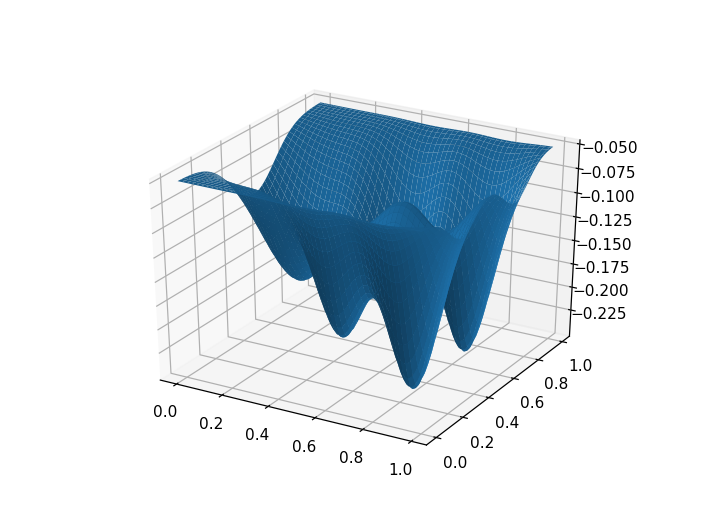

<IPython.core.display.Javascript object>


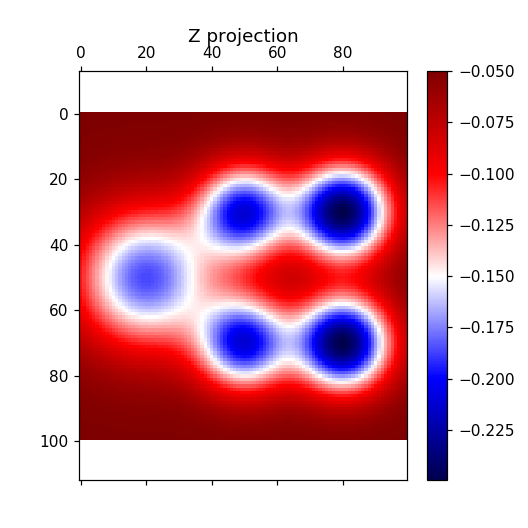

<IPython.core.display.Javascript object>


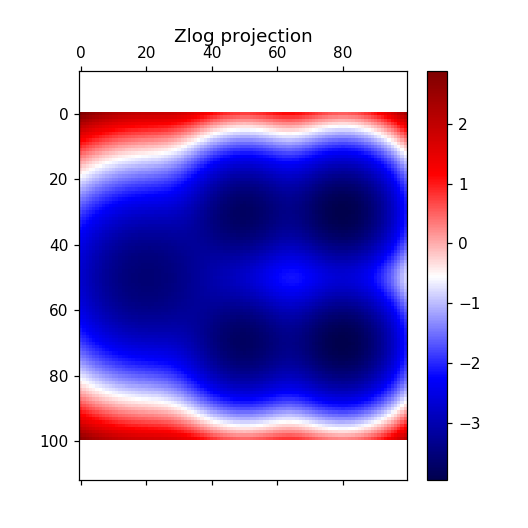

<IPython.core.display.Javascript object>


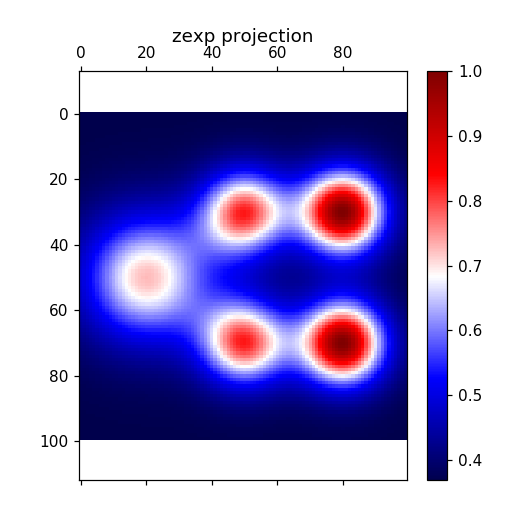

<IPython.core.display.Javascript object>


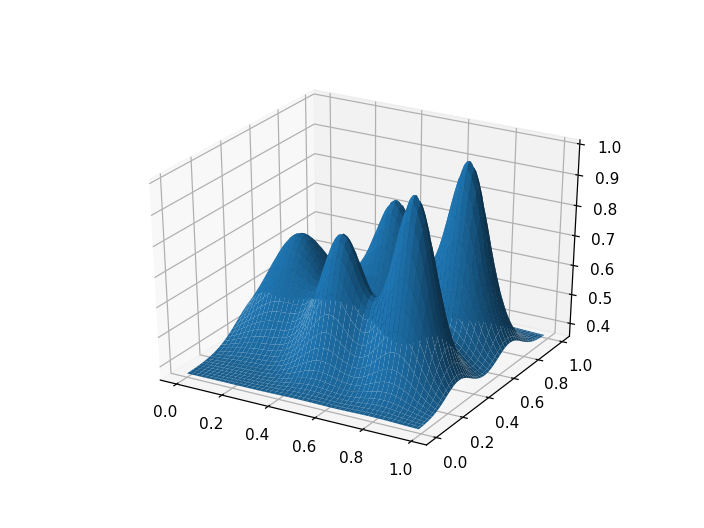

In [6]:
# 4
%matplotlib notebook
print(zs)
print((zs-min(zs))/-min(zs))
Z = (zs-max(zs))/-min(zs)
Z = Z.reshape(X.shape)*0.2
Z -=0.05
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
plt.matshow(Z, aspect=1, cmap=plt.get_cmap('seismic'))
plt.title('Z projection')
plt.colorbar()
plt.axis('equal')
plt.show()

zlog = -np.log(np.abs(zs))
zlog = zlog.reshape(X.shape)
plt.matshow(zlog, aspect=1, cmap=plt.get_cmap('seismic'))
plt.title('Zlog projection')
plt.colorbar()
plt.axis('equal')
plt.show()

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, zlog)
zexp = np.exp(-((zs-min(zs))/-min(zs)))
zexp = zexp.reshape(X.shape)
plt.matshow(zexp, aspect=1, cmap=plt.get_cmap('seismic'))
plt.title('zexp projection')
plt.colorbar()
plt.axis('equal')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, zexp)


In [8]:
# 5
parameters['reorder_dofs_serial'] = False
mesh = UnitSquareMesh(N, N)  # 8X8 rectangles, each divided in 2 triangle, hence 128 cells, and 81 (9^2) vertices
Vhat = FunctionSpace(mesh, 'P', 1)  # P returns Lagrangian polynomials, 1 is the degree of the FE

<IPython.core.display.Javascript object>


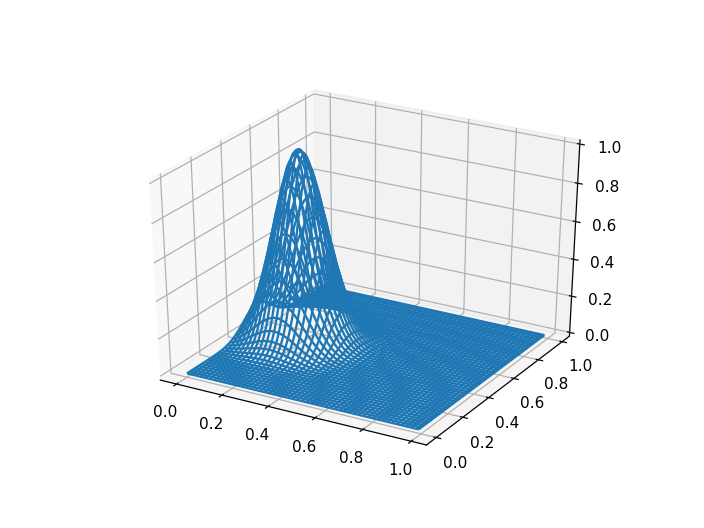

In [18]:
# 6
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(0, 1.0, 1 / M)
y = np.arange(0, 1.0, 1 / M)
X, Y = np.meshgrid(x, y)
ui = np.array(fun(np.ravel(X), np.ravel(Y), 0.2, 0.5, 0.1))
ui = (ui-min(ui))/max(ui)
Ui = ui.reshape(X.shape)
# Z2 = z2.reshape(X.shape)
# ax.plot_surface(X, Y, Ui) 
# ax.plot_surface(X, Y, Z2, linewidth=1) 
ax.plot_wireframe(X, Y, Ui) 


## Class functionFactory(Vhat, N, M)

Vhat is the function space buit on the mesh<br>
N is the dimension of the mesh<br>
M is the dimension of the input matrix<br>
The instance of the class can be directly evaluated by passing it a matrix, and the desired fenics function si returned.<br>
The function <i>plot(mat, title)</i> plots the function on the space.

In [9]:
# 6
from Dependencies.functionFactory import *
# from makeFunction import * 
factory = functionFactory(Vhat, N, M)

<IPython.core.display.Javascript object>


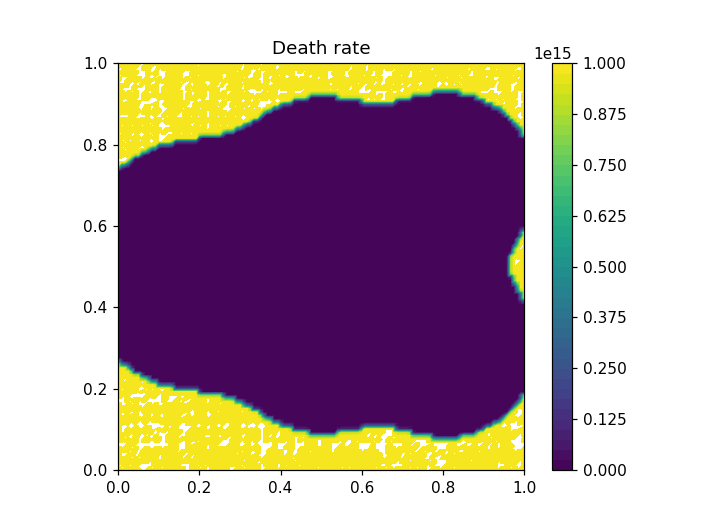

<IPython.core.display.Javascript object>


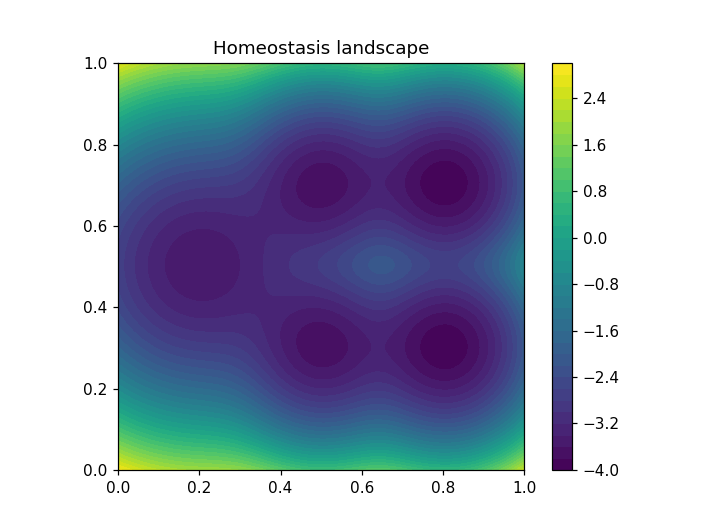

<IPython.core.display.Javascript object>


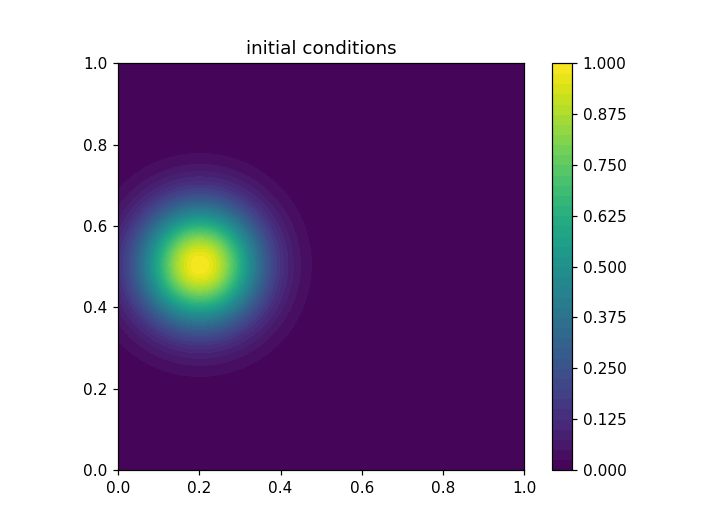

<IPython.core.display.Javascript object>


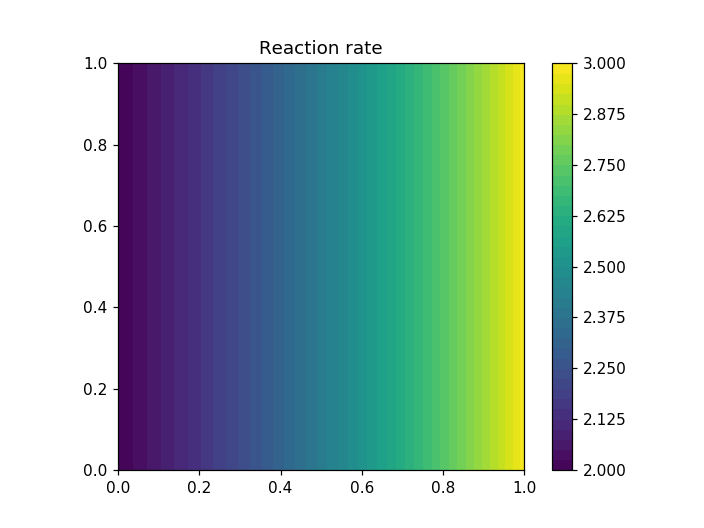

In [10]:
# 6
%matplotlib notebook

uhmst = zexp.reshape(X.shape)
uhmst[uhmst<0.4]=1e-15
cDth = 1. / uhmst.T
cDthFct = factory(cDth)
factory.plot(cDth, title='Death rate')

zlog = -np.log(np.abs(zs))
zlogFct = factory(zlog)
factory.plot(zlog, title='Homeostasis landscape')

# Very basic initial conditon
UiFct = factory(0.1*Ui.T)
factory.plot(Ui.T, title='initial conditions')


def rct(x_, y_):
    return 1 + 2**x_


cRctMat = np.array(rct(np.ravel(X), np.ravel(Y)))
cRctMat = cRctMat.reshape(X.shape)
cRctFct = factory(cRctMat.T)
factory.plot(cRctMat.T,title='Reaction rate')




In [11]:
# 6
def R1(u_):
    uv = u_.vector().get_local()
    cDth = cDthFct.vector().get_local()
    cRct = cRctFct.vector().get_local()
    temp = (cDth * uv)
    temp[temp > dbar] = dbar
    temp = (1 - temp)*cRct
    return temp


def v1():
    return zlogFct


def boundary(x, on_boundary):
    return on_boundary

# Differtiation rate
# Needs to be 1d --> np-ravel
def a(x_,y_):
    return 0.5*(1 - x_/max(x_))

# PT/ direction of the differentiation
def c_k_x(x_, y_):
    return x_**2

def c_k_y(x_, y_):
    return 0*y_

<IPython.core.display.Javascript object>


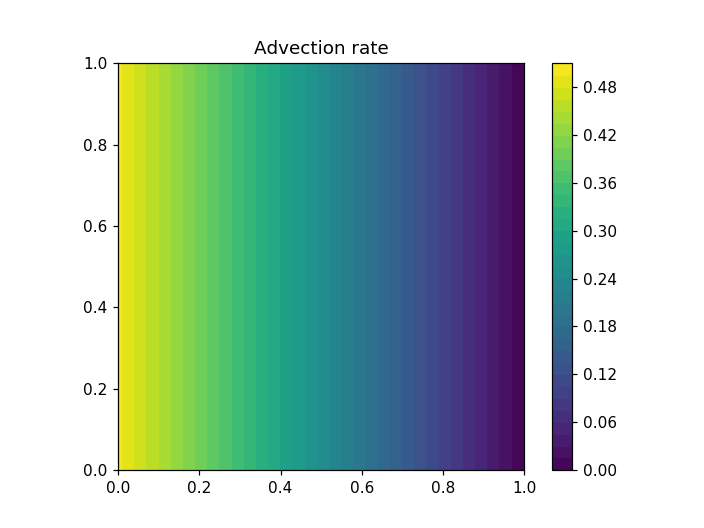

<IPython.core.display.Javascript object>


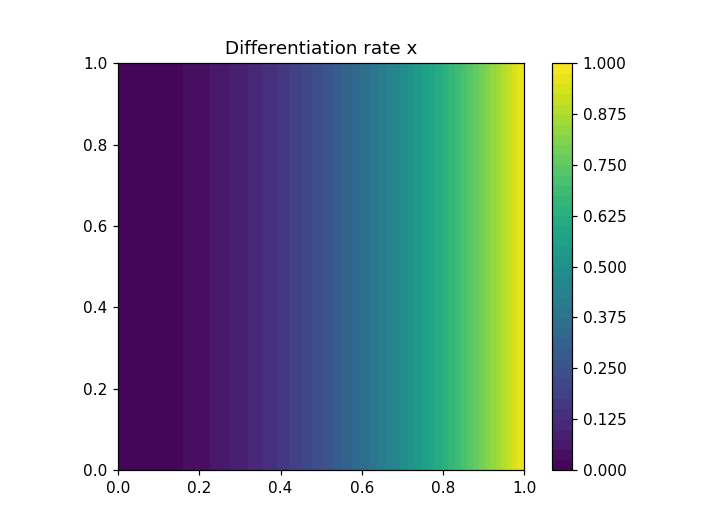

In [12]:
# 6
cAdvMat = np.array(a(np.ravel(X), np.ravel(Y)))
cAdvMat = cAdvMat.reshape(X.shape)
cAdvFct = factory(cAdvMat.T)
factory.plot(cAdvMat.T, title='Advection rate')

cAMat_x = np.array(c_k_x(np.ravel(X), np.ravel(Y)))
cAMat_x = cAMat_x.reshape(X.shape)
cAFct_x = factory(cAMat_x.T)
factory.plot(cAMat_x.T, title='Differentiation rate x')


cAMat_y = np.array(c_k_y(np.ravel(X), np.ravel(Y)))
cAMat_y = cAMat_y.reshape(Y.shape)
cAFct_y = factory(cAMat_y.T)
# factory.plot(cAMat_y.T, title='Differentiation rate y')


def v2_x(u_):
#     cAdv = cDthFct.vector().get_local()
    cAdv = cAdvFct.vector().get_local()
    cA = cAFct_x.vector().get_local()
    cRct = cRctFct.vector().get_local()
    return cA*(1-cAdv)*cRct

def v2_y(u_):
#     cAdv = cDthFct.vector().get_local()
    cAdv = cAdvFct.vector().get_local()
    cA = cAFct_y.vector().get_local()
    cRct = cRctFct.vector().get_local()
    return cA*(1-cAdv)*cRct

t = 0.40: difference = 1.95
t = 0.80: difference = 3.18
t = 1.20: difference = 1.58
t = 1.60: difference = 0.158
t = 2.00: difference = 0.0536
t = 2.40: difference = 0.0177
t = 2.80: difference = 0.00598
t = 3.20: difference = 0.00199
t = 3.60: difference = 0.000663
t = 4.00: difference = 0.000221
t = 4.40: difference = 7.36e-05
t = 4.80: difference = 2.48e-05
t = 5.20: difference = 8.04e-06
t = 5.60: difference = 2.77e-06
t = 6.00: difference = 8.45e-07


<IPython.core.display.Javascript object>


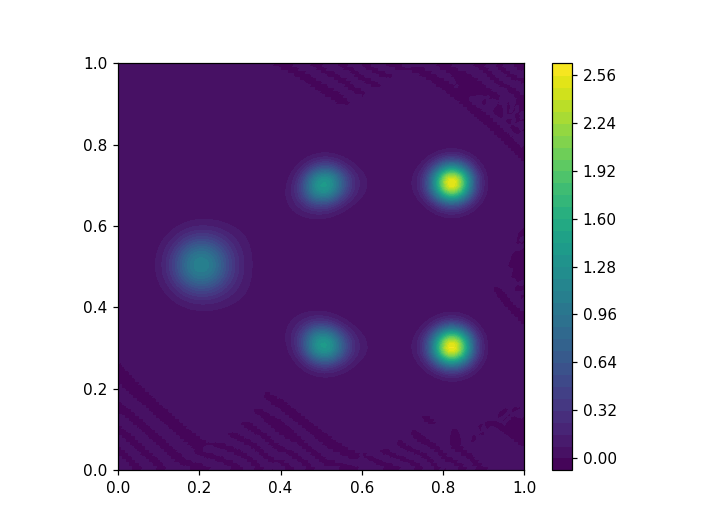

In [13]:
# 7
# %matplotlib notebook

zero = Constant(0)
bc = DirichletBC(Vhat, zero, boundary)

u = TrialFunction(Vhat)  # here it is just defined as an unknown to define a.
v = TestFunction(Vhat)
u_n = Function(Vhat)
R = Function(Vhat)
V2Fct_x = Function(Vhat) 
V2Fct_y = Function(Vhat) 

u_n = interpolate(UiFct, Vhat) # initial value

# plt.figure()
# p = plot(u_n)
# plt.colorbar(p)
# plt.show()

T = 80.0  # final time
num_step = 200
dt = T / num_step
k = 1./dt
tol = 1e-6

R.vector()[:] = R1(u_n)
V2Fct_x.vector()[:] = v2_x(u_n)
V2Fct_y.vector()[:] = v2_y(u_n)

F = dot((u-u_n)*k,v)*dx + nu * dot(grad(u), grad(v)) * dx + dot(nabla_grad(v1())*u, nabla_grad(v)) * dx - \
    dot( R*u, v) * dx - dot(V2Fct_x*u, v.dx(0))* dx - dot(V2Fct_y*u, v.dx(1))* dx

u = Function(Vhat)
a = lhs(F)
L = rhs(F)
t = 0

## uncomment to save the solution onto pvd files. Can be used to plot dynamically in paraview
# vtkfile = File('framework2/solution.pvd')
# vtkfile << (u_n, t)

for n in range(num_step):
    R.vector()[:] = R1(u_n)
    V2Fct_x.vector()[:] = v2_x(u_n)
    V2Fct_y.vector()[:] = v2_y(u_n)
    t+=dt
    solve(a == L, u, bc)
    u_e = interpolate(u_n, Vhat)
    error = np.abs(u_e.vector().get_local() - u.vector().get_local()).max()
    print('t = %.2f: difference = %.3g' % (t, error)) #relative errror
    if (error < tol):
        break
#     vtkfile << (u, t)
    u_n.assign(u)
    
plt.figure()
p = plot(u)
plt.colorbar(p)
plt.show()


<IPython.core.display.Javascript object>


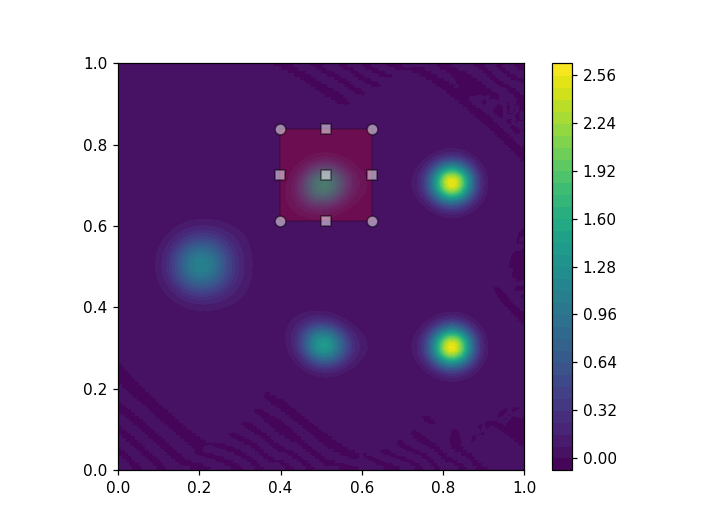


      click  -->  release


In [14]:
# 8
from matplotlib.widgets import RectangleSelector
def line_select_callback(eclick, erelease):
    'eclick and erelease are the press and release events'
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    print("(%3.2f, %3.2f) --> (%3.2f, %3.2f)" % (x1, y1, x2, y2))
    print(" The button you used were: %s %s" % (eclick.button, erelease.button))



fig, current_ax = plt.subplots()                 # make a new plotting range
# p = plot(UiFct)
p = plot(u)
plt.colorbar(p)
def toggle_selector(event):
    print(' Key pressed.')
    if event.key in ['Q', 'q'] and toggle_selector.RS.active:
        print(' RectangleSelector deactivated.')
        toggle_selector.RS.set_active(False)
    if event.key in ['A', 'a'] and not toggle_selector.RS.active:
        print(' RectangleSelector activated.')
        toggle_selector.RS.set_active(True)

print("\n      click  -->  release")

# drawtype is 'box' or 'line' or 'none'
toggle_selector.RS = RectangleSelector(current_ax, line_select_callback,
                                       drawtype='box', useblit=True,
                                       button=[1, 3],  # don't use middle button
                                       minspanx=5, minspany=5,
                                       spancoords='pixels',
                                       interactive=True)
plt.connect('key_press_event', toggle_selector)
plt.show()



In [16]:
# print(toggle_selector.RS.geometry)
x1, x2, y1 ,y2, z = toggle_selector.RS.geometry.T
print(x1)
print(x2)
print(y1)
print(y2)


[0.61286615 0.39873882]
[0.61286615 0.62601155]
[0.83743325 0.62601155]
[0.83743325 0.39873882]


In [17]:
p1 = Point(x1[0], x1[1])
p2 = Point(y1[0], y1[1])
# print(p1.x())
# print(p1.y())
# print(p2.x())
# print(p2.y())

NewMesh = RectangleMesh(p1,p2,N,N)

VInt = FunctionSpace(NewMesh, "Lagrange", 2)
uInt = project(u, VInt)
print(assemble(uInt*dx))
# plt.figure()
# plot(NewMesh)

0.00010438438480452823
